In [5]:
# show where this code is running
import os
print("Current working directory:", os.getcwd())

Current working directory: /home/fynley17/CODESPACE/Week10 - Data augmentation


Starting training...


Epoch 1/5: 100%|██████████| 82/82 [04:01<00:00,  2.95s/it]


Epoch 1/5, Loss: 1.9658


Epoch 2/5: 100%|██████████| 82/82 [02:56<00:00,  2.16s/it]


Epoch 2/5, Loss: 1.8305


Epoch 3/5: 100%|██████████| 82/82 [02:11<00:00,  1.60s/it]


Epoch 3/5, Loss: 1.7391


Epoch 4/5: 100%|██████████| 82/82 [02:23<00:00,  1.75s/it]


Epoch 4/5, Loss: 1.6837


Epoch 5/5: 100%|██████████| 82/82 [02:29<00:00,  1.83s/it]


Epoch 5/5, Loss: 1.6225
Test Accuracy: 43.90%


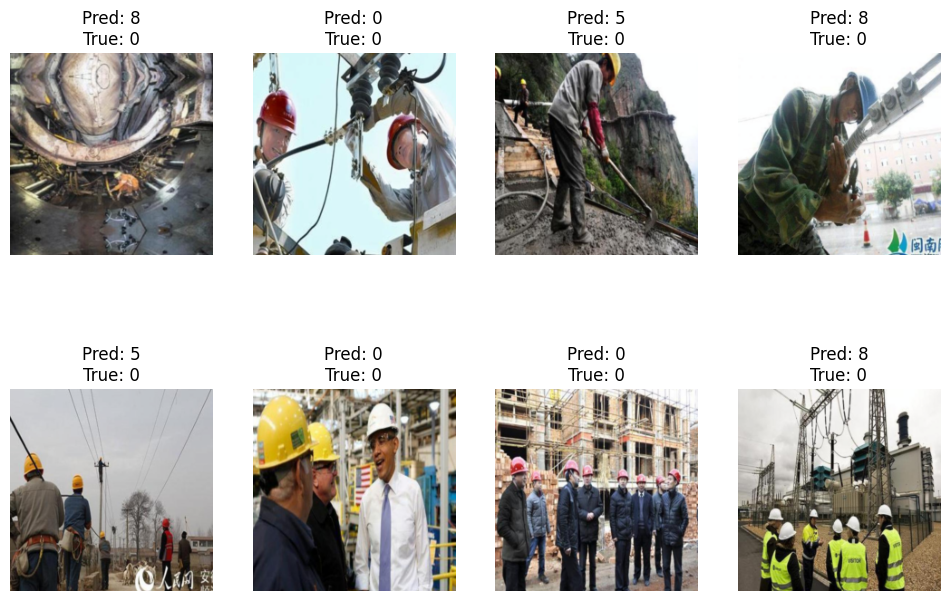

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# 1. DEFINE CUSTOM DATASET CLASS
class SeparateImageLabelDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        
        # specific to your file types
        self.images = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        
        # Define your classes manually here if you know them, 
        # otherwise the model output layer will be sized incorrectly.
        # Example: If your highest class ID in the text files is 8, you need at least 9 classes.
        self.classes = [str(i) for i in range(10)] # Assuming 10 classes (0-9) based on your error msg
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load Image
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        
        # Load Label
        label_name = os.path.splitext(img_name)[0] + '.txt' 
        label_path = os.path.join(self.label_dir, label_name)
        
        # --- FIX START ---
        label = 0 # Default if empty
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                content = f.read().strip()
                if content:
                    # Split by new line to get the first object
                    first_line = content.split('\n')[0]
                    # Split by space ("8 0.5 0.5...") -> ["8", "0.5", ...]
                    # Take the first element (the class ID) and convert to int
                    label = int(first_line.split()[0])

        if self.transform:
            image = self.transform(image)

        return image, label

# 2. SETUP PATHS
data_dir = './data'
# Adjust these paths to match your folder names
train_img_dir = os.path.join(data_dir, 'train/images')
train_lbl_dir = os.path.join(data_dir, 'train/labels')
test_img_dir = os.path.join(data_dir, 'test/images')
test_lbl_dir = os.path.join(data_dir, 'test/labels')

# 3. TRANSFORMS
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 4. LOAD DATASETS (Using the Custom Class)
train_dataset = SeparateImageLabelDataset(train_img_dir, train_lbl_dir, transform=train_transforms)
test_dataset = SeparateImageLabelDataset(test_img_dir, test_lbl_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# 5. MODEL SETUP
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# We use the length of the hardcoded classes list, or you can hardcode a number (e.g., 2 or 10)
num_classes = len(train_dataset.classes) 
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 6. TRAINING LOOP
print("Starting training...")
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    # Added tqdm for progress bar
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# 7. EVALUATION
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Save model
torch.save(model.state_dict(), 'model.pth')

# 8. VISUALIZATION
# Fixed .next() error for Python 3
dataiter = iter(test_loader)
images, labels = next(dataiter) 
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

fig = plt.figure(figsize=(12, 8))
# Ensure we don't try to plot more images than exist in the batch
num_to_show = min(8, len(images))
for idx in range(num_to_show):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    # Mapping back to class names if available
    pred_class = train_dataset.classes[predicted[idx]] if predicted[idx] < len(train_dataset.classes) else predicted[idx]
    true_class = train_dataset.classes[labels[idx]] if labels[idx] < len(train_dataset.classes) else labels[idx]
    ax.set_title(f'Pred: {pred_class}\nTrue: {true_class}')
plt.show()